<a href="https://colab.research.google.com/github/BARUD77/Homework2/blob/main/Homework2_regex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import torch
import torch.nn as nn
import tiktoken



# Cloning repository and mounting drive

In [2]:
%cd /content
!git -C Homework2 pull || git clone https://github.com/BARUD77/Homework2.git
%cd Homework2

/content
fatal: cannot change to 'Homework2': No such file or directory
Cloning into 'Homework2'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 12), reused 19 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 1.24 MiB | 28.93 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Homework2


In [3]:
ll

total 4688
-rw-r--r-- 1 root    2775 Nov  4 09:54 artifact_simulation.py
-rw-r--r-- 1 root 2851073 Nov  4 09:54 cleaned_text.txt
-rw-r--r-- 1 root    1381 Nov  4 09:54 dataset.py
-rw-r--r-- 1 root    6371 Nov  4 09:54 extract_sheet_changes.py
-rw-r--r-- 1 root    8623 Nov  4 09:54 extract_txt.py
-rw-r--r-- 1 root   10377 Nov  4 09:54 frame_extractor.py
-rw-r--r-- 1 root   87694 Nov  4 09:54 Homework2.ipynb
-rw-r--r-- 1 root   29002 Nov  4 09:54 Homework2_regex.ipynb
-rw-r--r-- 1 root   94232 Nov  4 09:54 IFD_creation.ipynb
-rw-r--r-- 1 root   32209 Nov  4 09:54 LLM_Homework_1_Hermon_Teklesenbet_100064487.ipynb
-rw-r--r-- 1 root   91180 Nov  4 09:54 loss_plot.png
-rw-r--r-- 1 root 1527298 Nov  4 09:54 merged_corpus.txt
-rw-r--r-- 1 root    4928 Nov  4 09:54 model.py
-rw-r--r-- 1 root    7763 Nov  4 09:54 train.py
-rw-r--r-- 1 root    8860 Nov  4 09:54 Untitled-1.ipynb


# Loading the cleaned and merged text file

In [4]:
with open("cleaned_text.txt", "r") as f:
    cleaned_text = f.read()


# Tokenization with both regex and bpe tokenizers

### Regex tokenizer

In [5]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.tokens2ids = {tok: i for i, tok in enumerate(vocab)}
        self.ids2tokens = {i: tok for tok, i in self.tokens2ids.items()}
        self.unk_id = self.tokens2ids["<|unk|>"]  # required

    def encode(self, text):
        tokens = re.split(r"([.,:;?_!\"'()\[\]—\-\s])", text)
        tokens = [t.strip() for t in tokens if t and t.strip()]
        return [self.tokens2ids.get(t, self.unk_id) for t in tokens]

    def decode(self, ids):
        text = " ".join(self.ids2tokens[i] for i in ids)
        return re.sub(r'\s+([,.?!"()\'])', r'\1', text)

In [6]:
import re
import unicodedata

# 0) (optional) clean non-printables to avoid odd tokens like '\x001'
def strip_nonprintable(s):
    return ''.join(ch if unicodedata.category(ch)[0] != 'C' else ' ' for ch in s)

cleaned_text = strip_nonprintable(cleaned_text)

# 1) tokenize the corpus once to build the base vocab
preprocessed = re.split(r"([.,:;?_!\"'()\[\]—\-\s])", cleaned_text)
preprocessed = [t.strip() for t in preprocessed if t and t.strip()]

# 2) build vocab set from corpus (no specials yet)
base_vocab = set(preprocessed)

# 3) add specials up front in a deterministic order
specials = ["<|pad|>", "<|bos|>", "<|eos|>", "<|unk|>"]
# exclude any duplicates of specials from the base set
base_vocab -= set(specials)

# 4) finalize the ordered vocab: specials first, then sorted tokens
vocab = specials + sorted(base_vocab)
vocab_size = len(vocab)
print("Vocab size =", vocab_size)

# 5) construct the tokenizer with this *fixed* vocab
regextokenizer = SimpleTokenizer(vocab)

Vocab size = 29916


# Preparing the dataloader

In [7]:
from model import GPTModel

gpt2=False
vocab_size = vocab_size
tokenizer = regextokenizer

GPT_CONFIG = {
"vocab_size": vocab_size, # Vocabulary size
"context_length": 256, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

model = GPTModel(GPT_CONFIG)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model (Millions): {total_params/1_000_000}")
print("-"*100)

Total number of parameters in the model (Millions): 131.175936
----------------------------------------------------------------------------------------------------


In [8]:
from dataset import create_dataloader_v1
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(cleaned_text))
train_data = cleaned_text[:split_idx]
val_data = cleaned_text[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    gpt2,
    tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    gpt2,
    tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [9]:
total_train_characters = len(train_data)
total_train_tokens = len(tokenizer.encode(train_data))

print("Train Characters :", total_train_characters)
print("Train Tokens :", total_train_tokens)

print("="*100)

total_val_characters = len(val_data)
total_val_tokens = len(tokenizer.encode(val_data))

print("Validation Characters:", total_val_characters)
print("Validation Tokens:", total_val_tokens)

print("="*100)
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    break
print("="*100)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    break

Train Characters : 2506253
Train Tokens : 537969
Validation Characters: 278473
Validation Tokens: 61105
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


# Pretraining

In [10]:
from train import train_model_simple
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

# estimate a token budget: ~5 epochs worth
B, T = next(iter(train_loader))[0].shape  # (B, T)
tokens_per_epoch = len(train_loader) * B * T
target_tokens = 30 * tokens_per_epoch

train_losses, val_losses, tokens_seen = train_model_simple(
    model, gpt2, train_loader, val_loader, optimizer, device,
    num_epochs=30,                 # large cap; early stopping will stop earlier
    eval_freq=200,                  # evaluate every N steps (tune to your speed)
    eval_iter=5,
    start_context="Finally, given the broad spectrum of capabilities displayed by GPT-3",
    tokenizer=tokenizer,
    # early stopping knobs
    early_stop=True, patience=5, min_delta=1e-3,
    save_path="checkpoints/regex/best.pt",
    use_plateau_lr=True, lr_factor=0.5, lr_patience=2, min_lr=1e-5,
    max_tokens_seen=target_tokens
)


Ep 1 (Step 000000): Train 9.569 | Val 9.512 | tokens 512
  ↳ new best; saved to checkpoints/regex/best.pt
Ep 1 (Step 000200): Train 6.546 | Val 5.602 | tokens 102,912
  ↳ new best; saved to checkpoints/regex/best.pt
Ep 1 (Step 000400): Train 6.361 | Val 5.403 | tokens 205,312
  ↳ new best; saved to checkpoints/regex/best.pt
Ep 1 (Step 000600): Train 5.814 | Val 5.220 | tokens 307,712
  ↳ new best; saved to checkpoints/regex/best.pt
Ep 1 (Step 000800): Train 5.237 | Val 5.182 | tokens 410,112
  ↳ new best; saved to checkpoints/regex/best.pt
Ep 1 (Step 001000): Train 5.161 | Val 5.098 | tokens 512,512
  ↳ new best; saved to checkpoints/regex/best.pt
Finally, given the broad spectrum of capabilities displayed by GPT - 3. Finally, we hope - 8B. This model on a dataset. 5. We develop the model is the model to ensure a set of DeepSeek - tune : A for the model. During a range of model is better, the context in the model
Ep 2 (Step 001200): Train 5.350 | Val 5.039 | tokens 614,912
  ↳ new best

# Plotting training and validation losses

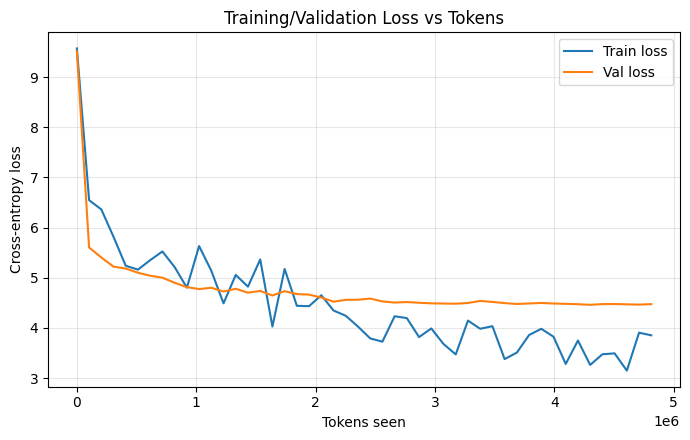

In [11]:
import matplotlib.pyplot as plt

def plot_losses(tokens_seen, train_losses, val_losses, save_path=None):
    """
    tokens_seen: list from train_model_simple (logged at each eval)
    train_losses, val_losses: same length as tokens_seen
    """
    if not (len(tokens_seen) == len(train_losses) == len(val_losses)):
        raise ValueError("tokens_seen, train_losses, val_losses must have same length")

    plt.figure(figsize=(7,4.5))
    plt.plot(tokens_seen, train_losses, label="Train loss")
    plt.plot(tokens_seen, val_losses, label="Val loss")
    plt.xlabel("Tokens seen")
    plt.ylabel("Cross-entropy loss")
    plt.title("Training/Validation Loss vs Tokens")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

plot_losses(tokens_seen, train_losses, val_losses, save_path="loss_plot.png")

# Hyperparameter tuning

In [13]:
import math, json, random, copy, os, time
import torch
from train import train_model_simple  # your training loop

def make_model_and_optim(cfg, device, lr, weight_decay):
    # IMPORTANT: re-init a fresh model & optimizer each trial
    model = GPTModel({**cfg}).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.95))
    return model, optim

def sample_hparams():
    # Log-uniform for LR
    lr = 10 ** random.uniform(-5, -2.3)          # ~1e-5 .. 5e-3
    wd = random.choice([0.0, 0.05, 0.1, 0.15])   # discrete choices are fine
    lr_factor = random.uniform(0.3, 0.7)
    lr_patience = random.choice([1, 2, 3])
    patience = random.choice([3, 5, 7])
    min_delta = random.choice([5e-4, 1e-3, 2e-3])
    return dict(lr=lr, weight_decay=wd, lr_factor=lr_factor,
                lr_patience=lr_patience, patience=patience, min_delta=min_delta)

def run_trial(trial_id, base_cfg, device, token_budget_multiplier=6):
    # keep trials short: a few epochs worth of tokens
    B, T = next(iter(train_loader))[0].shape
    tokens_per_epoch = len(train_loader) * B * T
    max_tokens = token_budget_multiplier * tokens_per_epoch

    hp = sample_hparams()
    model, optimizer = make_model_and_optim(base_cfg, device, hp["lr"], hp["weight_decay"])
    save_dir = f"checkpoints/regex/trial_{trial_id}"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "best.pt")

    train_losses, val_losses, tokens_seen = train_model_simple(
        model=model, gpt2=gpt2,
        train_loader=train_loader, val_loader=val_loader,
        optimizer=optimizer, device=device,
        num_epochs=30,             # cap; early stop will end earlier
        eval_freq=200, eval_iter=8,
        start_context="Finally, given the broad spectrum of capabilities displayed by GPT-3",
        tokenizer=tokenizer,
        early_stop=True, patience=hp["patience"], min_delta=hp["min_delta"],
        save_path=save_path,
        use_plateau_lr=True, lr_factor=hp["lr_factor"], lr_patience=hp["lr_patience"], min_lr=1e-5,
        max_tokens_seen=max_tokens
    )

    best_val = min(val_losses) if val_losses else float("inf")
    result = {
        "trial_id": trial_id,
        **hp,
        "best_val": best_val,
        "tokens_seen": int(tokens_seen[-1]) if tokens_seen else 0,
        "save_path": save_path
    }
    # free GPU mem between trials
    del model, optimizer
    torch.cuda.empty_cache()
    return result

# ---- run N trials ----
device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(123); torch.manual_seed(123)

N_TRIALS = 30  # start small; increase if you have time/compute
results = []
for t in range(N_TRIALS):
    res = run_trial(trial_id=t, base_cfg=GPT_CONFIG, device=device, token_budget_multiplier=4)
    print(f"[trial {t}] val={res['best_val']:.4f}  lr={res['lr']:.2e}  wd={res['weight_decay']}")
    results.append(res)

# pick best
results = sorted(results, key=lambda x: x["best_val"])
print("Best:", results[0])
with open("tuning_results.json", "w") as f:
    json.dump(results, f, indent=2)


Ep 1 (Step 000000): Train 10.435 | Val 10.426 | tokens 512
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Ep 1 (Step 000200): Train 7.384 | Val 6.893 | tokens 102,912
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Ep 1 (Step 000400): Train 6.692 | Val 6.122 | tokens 205,312
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Ep 1 (Step 000600): Train 6.410 | Val 5.760 | tokens 307,712
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Ep 1 (Step 000800): Train 5.614 | Val 5.576 | tokens 410,112
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Ep 1 (Step 001000): Train 6.003 | Val 5.452 | tokens 512,512
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Finally, given the broad spectrum of capabilities displayed by GPT - 3. 5 - 1. 5 - shot the model. For more. 5. 9. 6. 5. 4. 1. 0. 3. 2 : 0. 4. 5. 8 0 - shot. 4. 2 76., 0
Ep 2 (Step 001200): Train 5.819 | Val 5.332 | tokens 614,912
  ↳ new best; saved to checkpoints/regex/trial_0/best.pt
Ep 2 (